In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import yfinance as yf
import pandas as pd

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2025-03-13', end='2025-03-21', interval='1m')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
for i in range(21, 28, 8):
    data = pd.concat([data, yf.download(ticker, start=f'2025-03-{i+1}', end=f'2025-03-{i+8}', interval='1m')], axis=0)

for i in range(0, 8, 8):
    data = pd.concat([data, yf.download(ticker, start=f'2025-04-{i+1}', end=f'2025-04-{i+8}', interval='1m')], axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
data

Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Datetime,,,,,
2025-03-13 00:00:00+00:00,1.088850,1.088850,1.088850,1.088850,0
2025-03-13 00:01:00+00:00,1.088969,1.088969,1.088969,1.088969,0
2025-03-13 00:02:00+00:00,1.088969,1.088969,1.088969,1.088969,0
2025-03-13 00:03:00+00:00,1.088850,1.088850,1.088850,1.088850,0
2025-03-13 00:04:00+00:00,1.088969,1.088969,1.088969,1.088969,0
...,...,...,...,...,...
2025-04-07 22:54:00+00:00,1.092180,1.092180,1.092180,1.092180,0
2025-04-07 22:55:00+00:00,1.092061,1.092061,1.092061,1.092061,0


In [6]:
data.columns

MultiIndex([( 'Close', 'EURUSD=X'),
            (  'High', 'EURUSD=X'),
            (   'Low', 'EURUSD=X'),
            (  'Open', 'EURUSD=X'),
            ('Volume', 'EURUSD=X')],
           names=['Price', 'Ticker'])

In [7]:
def backtest_strategy(df, initial_balance, risk_per_trade, one_pip, exchange_rate):
    """
    Backtests an MA crossover strategy with risk-based position sizing.

    Parameters:
    - df: DataFrame with 'Signal' (1 = Buy, -1 = Sell) and 'Close' price.
    - initial_balance: Starting capital.
    - risk_per_trade: Fraction of capital risked per trade (e.g., 0.02 for 2%).
    - one_pip: Pip value.
    - lot_size: Standard lot size (1 lot = 100,000 units).
    - exchange_rate: Exchange rate for pip value calculation.

    Returns:
    - final balance and a DataFrame with equity curve.
    """

    # Convert lot size
    lot_size = 100000  
    pip_value = (one_pip * lot_size) / exchange_rate  

    # Initialize variables
    balance = initial_balance
    position = 0
    trade_size = 0  
    buy_price = 0  
    sell_price = 0  

    for i in range(len(df)):
        df['Balance'] = initial_balance
        
    trades = []  # Store trade details

    for i in range(len(df)):
        if df['Signal'].iloc[i] == 1 and position == 0:  # Buy
            position = 1
            buy_price = df['Close'].iloc[i]
            trade_size = (balance * risk_per_trade) / (10 * one_pip * pip_value * lot_size)  # Risk-based sizing
        elif df['Signal'].iloc[i] == -1 and position == 1:  # Sell
            position = 0
            sell_price = df['Close'].iloc[i]
            trade_profit = (sell_price - buy_price) * (1 / one_pip) * pip_value * trade_size  
            balance += trade_profit
            df['Balance'].iloc[i:] = balance  # Update balance in DataFrame
            trades.append({'Entry': buy_price, 'Exit': sell_price, 'Profit': trade_profit})
        elif df['Signal'].iloc[i] == -1 and position == 0:  # Short Sell
            position = -1
            sell_price = df['Close'].iloc[i]
            trade_size = (balance * risk_per_trade) / (10 * one_pip * pip_value * lot_size)
        elif df['Signal'].iloc[i] == 1 and position == -1:  # Buy to Close Short
            position = 0
            buy_price = df['Close'].iloc[i]
            trade_profit = (sell_price - buy_price) * (1 / one_pip) * pip_value * trade_size  
            balance += trade_profit
            df['Balance'].iloc[i:] = balance
            trades.append({'Entry': sell_price, 'Exit': buy_price, 'Profit': trade_profit})

    return balance, pd.DataFrame(trades)


In [8]:
def analyze_results(df, initial_balance, risk_per_trade, one_pip=0.0001, exchange_rate=1.1):
    """
    Analyzes backtest results: prints profit, trade stats, and plots the equity curve.

    Parameters:
    - df: DataFrame with signals and prices.
    - initial_balance: Starting capital.
    - risk_per_trade: Risk per trade as a fraction of capital.
    - one_pip: Pip value.
    - lot_size: Standard lot size (1 lot = 100,000 units).
    - exchange_rate: Exchange rate for pip calculation.
    """

    final_balance, trades = backtest_strategy(df, initial_balance, risk_per_trade, one_pip, exchange_rate)
    
    # Calculate total profit
    total_profit = final_balance - initial_balance
    
    return total_profit, trades  # Returning trades DataFrame for further analysis


In [9]:
import numpy as np
import pandas as pd
from itertools import product

def find_param(data, initial_balance=10000, risk_per_trade=0.01):
    # Rename columns
    data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    
    # Define parameter ranges
    short_periods = range(5, 51, 5)
    long_periods = range(20, 201, 5)
    
    # Precompute all moving averages
    ma_data = {}
    for period in set(short_periods) | set(long_periods):
        ma_data[period] = data['Close'].rolling(window=period).mean()
    
    # Create a DataFrame to store all moving averages
    ma_df = pd.DataFrame(ma_data, index=data.index)
    ma_df = ma_df.join(data[['Close', 'High', 'Low', 'Open']])
    
    # Drop rows with any NaN values (due to rolling windows)
    ma_df = ma_df.dropna()
    
    # Initialize variables for tracking optimal results
    max_profit = -np.inf
    short_period_opt = 0
    long_period_opt = 0
    trades_opt = 0
    best_df = None
    
    # Iterate over valid period combinations
    for short_period, long_period in product(short_periods, long_periods):
        if long_period <= short_period:
            continue  # Skip invalid combinations
        
        # Extract relevant moving averages
        df = ma_df[['Close', 'High', 'Low', 'Open']].copy()
        df['MA_short'] = ma_df[short_period]
        df['MA_long'] = ma_df[long_period]
        
        # Generate signals
        df['Signal'] = np.where(df['MA_short'] > df['MA_long'], 1, 0)
        df['Signal'] = df['Signal'].diff()
        
        # Assign buy/sell signals
        df['Buy_Signal'] = np.where(df['Signal'] == 1, df['Close'], np.nan)
        df['Sell_Signal'] = np.where(df['Signal'] == -1, df['Close'], np.nan)
        
        # Compute profit and trades
        profit, trades = analyze_results(df, initial_balance, risk_per_trade)
        
        # Update optimal parameters if profit is higher
        if profit > max_profit:
            max_profit = profit
            short_period_opt = short_period
            long_period_opt = long_period
            trades_opt = trades
            best_df = df.copy()  # Store only the optimal DataFrame
    
    return short_period_opt, long_period_opt, max_profit, trades_opt, best_df

In [10]:
initial_balance = 10000; risk_per_trade = 0.02

In [ ]:
short_period_opt, long_period_opt, max_profit, trades_opt, df_opt = find_param(data)

In [ ]:
short_period_opt, long_period_opt

(10, 170)

In [13]:
df = df_opt

In [14]:
trades_opt

,Entry,Exit,Profit
0,1.089562,1.089206,-3.559589
1,1.088495,1.087784,-7.102345
2,1.087903,1.087429,-4.727563
3,1.088258,1.087548,-7.090369
4,1.085658,1.086366,7.061545
...,...,...,...
132,1.095770,1.096011,2.453813
133,1.096972,1.095530,-14.734943
134,1.093853,1.092896,-9.758450
135,1.093972,1.093494,-4.877596


In [15]:
def cleaned_data(data):
    df['MA_short'] = data['Close'].rolling(window=short_period_opt).mean()
    df['MA_long'] = data['Close'].rolling(window=long_period_opt).mean()

    data = df_opt[df['Signal'] != 0][['Signal', 'Balance']]
    data = data[1:]
    data['Profit'] = data['Balance'].diff()
    data['Profit'] = data['Profit'].replace(np.nan, 0)
    data = data.drop(columns=['Balance'])
    data['Time_Diff'] = data.index.diff()
    data = data[['Time_Diff', 'Signal', 'Profit']]
    data['Time_Diff']=data['Time_Diff'].shift(periods=-1)
    data['Profit']=data['Profit'].shift(periods=-1)
    data = data[::2]


    return df, data

In [16]:
df, data = cleaned_data(data)

In [17]:
short_period_opt

10

In [18]:
df_opt

,Close,High,Low,Open,MA_short,MA_long,Signal,Buy_Signal,Sell_Signal,Balance
Datetime,,,,,,,,,,
2025-03-13 03:19:00+00:00,1.089325,1.089325,1.089325,1.089325,1.089325,1.089392,NaN,NaN,NaN,10000.000000
2025-03-13 03:20:00+00:00,1.089443,1.089443,1.089443,1.089443,1.089313,1.089396,0.0,NaN,NaN,10000.000000
2025-03-13 03:21:00+00:00,1.089325,1.089325,1.089325,1.089325,1.089301,1.089399,0.0,NaN,NaN,10000.000000
2025-03-13 03:22:00+00:00,1.089443,1.089443,1.089443,1.089443,1.089313,1.089402,0.0,NaN,NaN,10000.000000
2025-03-13 03:23:00+00:00,1.089562,1.089562,1.089562,1.089562,1.089336,1.089406,0.0,NaN,NaN,10000.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-07 22:54:00+00:00,1.092180,1.092180,1.092180,1.092180,1.092037,1.091359,0.0,NaN,NaN,10173.890044
2025-04-07 22:55:00+00:00,1.092061,1.092061,1.092061,1.092061,1.092049,1.091359,0.0,NaN,NaN,10173.890044
2025-04-07 22:56:00+00:00,1.091941,1.091941,1.091941,1.091941,1.092037,1.091358,0.0,NaN,NaN,10173.890044


In [19]:
def plot_equity_curve(trades):
    print(f"Total Profit: ${max_profit:.2f}")
        
    # Number of trades
    num_trades = len(trades)
    print(f"Total Trades: {num_trades}")

    # Plot equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Balance'], label="Equity Curve", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Account Balance ($)")
    plt.title("Backtest Equity Curve")
    plt.legend()
    plt.show()


Total Profit: $173.89
Total Trades: 137


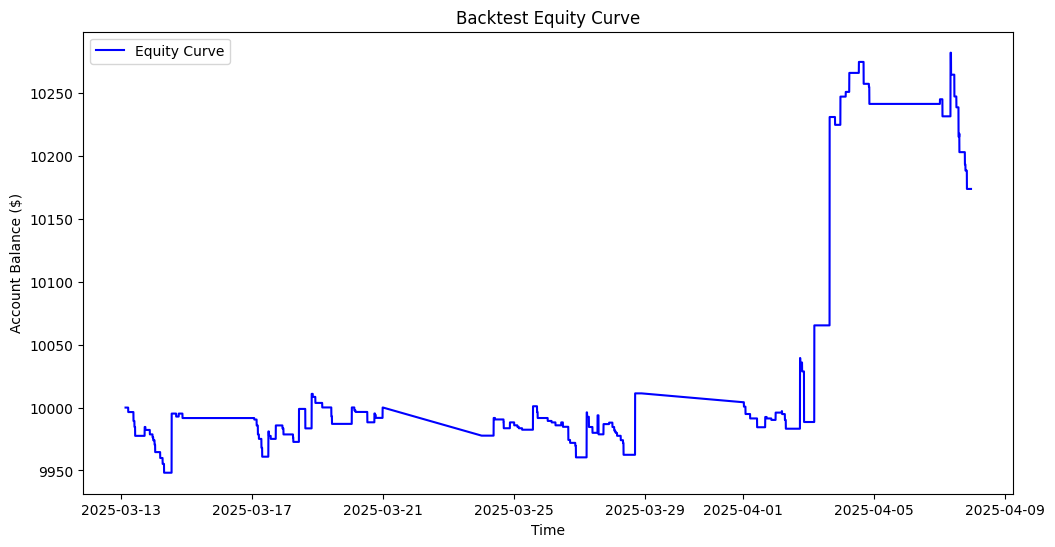

In [20]:
plot_equity_curve(trades_opt)

In [21]:
import mplfinance as mpf

def plot_chart():
    # Define the moving average plots
    ma_plots = [
        mpf.make_addplot(df['MA_short'], color='blue', width=0.5, label=f'{short_period_opt} MA'),
        mpf.make_addplot(df['MA_long'], color='red', width=0.5, label=f'{long_period_opt} MA')
    ]


    fig, ax = mpf.plot(df, type='candle', style='charles', volume=False, addplot=ma_plots, returnfig=True)

    # ✅ Set the figure DPI manually
    fig.set_dpi(300)

    plt.show()

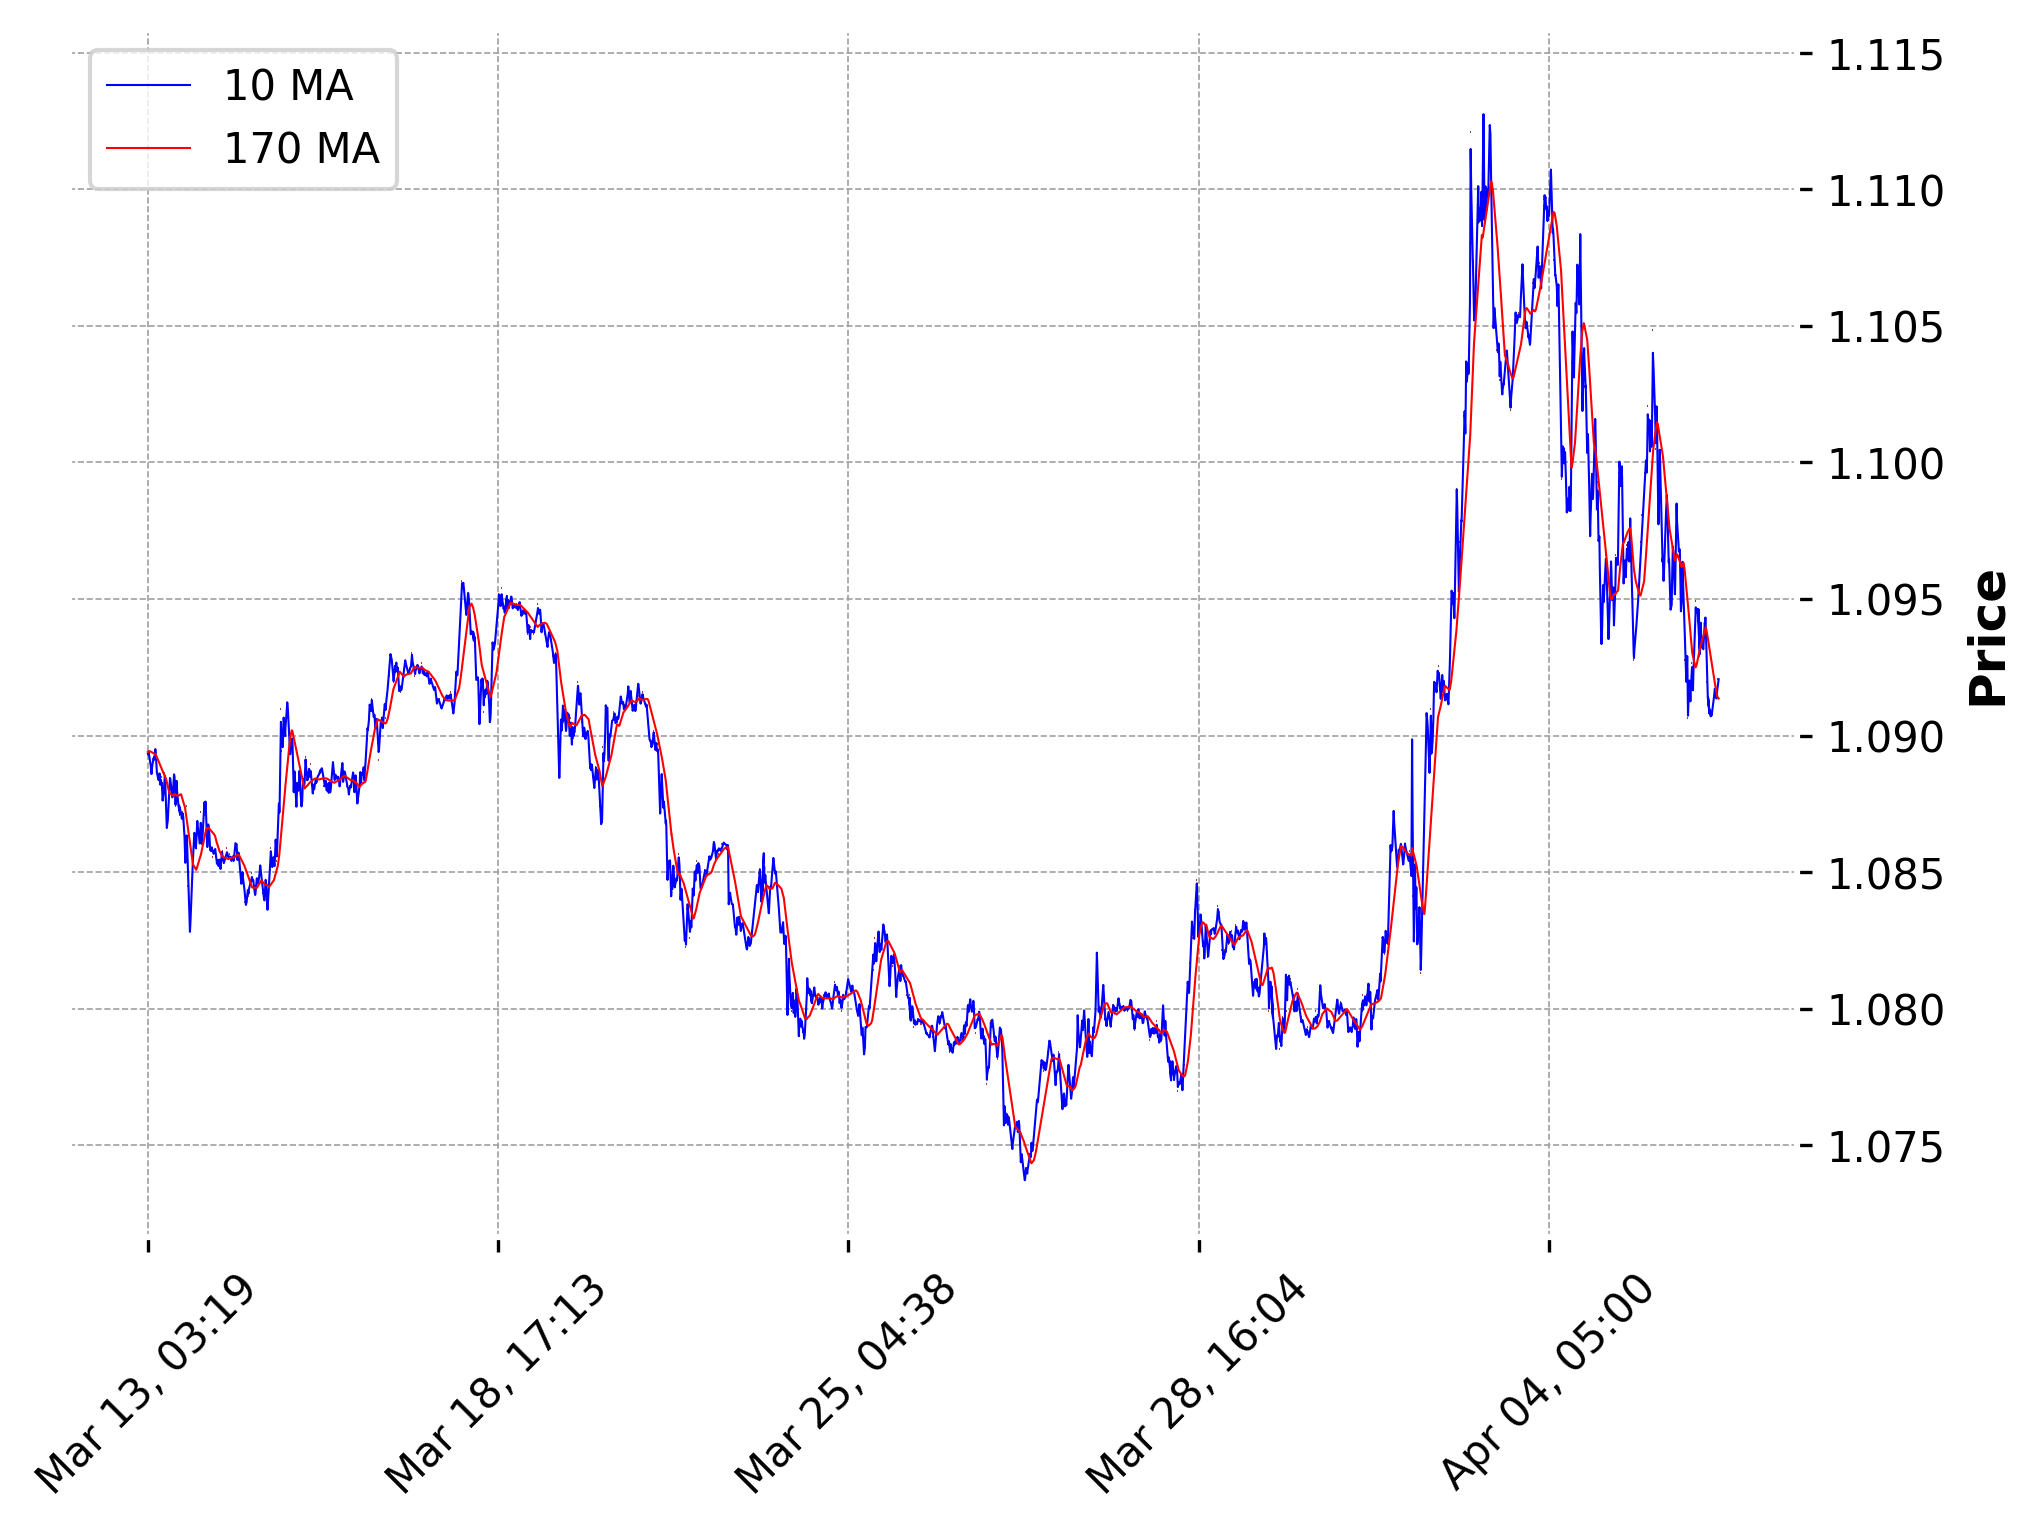

In [22]:
plot_chart()

In [23]:
data

,Time_Diff,Signal,Profit
Datetime,,,
2025-03-13 04:57:00+00:00,0 days 00:17:00,1.0,-3.559589
2025-03-13 08:29:00+00:00,0 days 00:36:00,1.0,-7.102345
2025-03-13 09:14:00+00:00,0 days 00:34:00,1.0,-4.727563
2025-03-13 10:01:00+00:00,0 days 00:17:00,1.0,-7.090369
2025-03-13 14:02:00+00:00,0 days 03:15:00,1.0,7.061545
...,...,...,...
2025-04-07 14:22:00+00:00,0 days 00:02:00,1.0,-14.734943
2025-04-07 17:00:00+00:00,0 days 01:27:00,1.0,-9.758450
2025-04-07 18:33:00+00:00,0 days 00:19:00,1.0,-4.877596


In [24]:
def processed_data(data):
    # Assuming data is your DataFrame
    # Convert Datetime
    data['Datetime'] = pd.to_datetime(data.index)
    data['Year'] = data['Datetime'].dt.year
    data['Month'] = data['Datetime'].dt.month
    data['Day'] = data['Datetime'].dt.day
    data['Hour'] = data['Datetime'].dt.hour
    data['Minute'] = data['Datetime'].dt.minute
    data['DayOfWeek'] = data['Datetime'].dt.dayofweek

    # Convert Time_Diff to hours
    data['Time_Diff_Hours'] = data['Time_Diff'].dt.total_seconds() / 3600

    data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
    data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
    data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

    data.index = range(0, len(data))
    data['Time_Diff_Hours'] = data['Time_Diff'].dt.total_seconds() / 3600

    # Map Signal to 0 and 1 for binary classification (if needed)
    data['Signal'] = data['Signal'].map({-1.0: 0, 1.0: 1})
    # Or one-hot encode for multi-class
    data = pd.get_dummies(data, columns=['Signal'], prefix='Signal')

    return data

In [25]:
data = processed_data(data)

In [26]:
# Features and target
features = ['Signal_1', 'Time_Diff_Hours',  'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']
target = 'Profit'

In [27]:
data[features]

,Signal_1,Time_Diff_Hours,Year,Month,Day,Hour,Minute,DayOfWeek,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,True,0.283333,2025,3,13,4,57,3,1.000000,6.123234e-17,0.433884,-0.900969
1,True,0.600000,2025,3,13,8,29,3,1.000000,6.123234e-17,0.433884,-0.900969
2,True,0.566667,2025,3,13,9,14,3,1.000000,6.123234e-17,0.433884,-0.900969
3,True,0.283333,2025,3,13,10,1,3,1.000000,6.123234e-17,0.433884,-0.900969
4,True,3.250000,2025,3,13,14,2,3,1.000000,6.123234e-17,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...
133,True,0.033333,2025,4,7,14,22,0,0.866025,-5.000000e-01,0.000000,1.000000
134,True,1.450000,2025,4,7,17,0,0,0.866025,-5.000000e-01,0.000000,1.000000
135,True,0.316667,2025,4,7,18,33,0,0.866025,-5.000000e-01,0.000000,1.000000
136,True,0.500000,2025,4,7,19,25,0,0.866025,-5.000000e-01,0.000000,1.000000


In [28]:
profit_unscaled = data['Profit']

In [29]:
from sklearn.preprocessing import MinMaxScaler

def scaled_data(data):
        
    # Features to scale
    features_to_scale = ['Time_Diff_Hours',  'Year', 'Month', 'Day', 'Hour', 'Minute', 'DayOfWeek']
    target = 'Profit'

    # Scale features
    feature_scaler = MinMaxScaler()
    data[features_to_scale] = feature_scaler.fit_transform(data[features_to_scale])

    # Scale target (Profit)
    target_scaler = MinMaxScaler()
    data[[target]] = target_scaler.fit_transform(data[[target]])

    return data

In [30]:
data = scaled_data(data)

In [31]:
data

,Time_Diff,Profit,Datetime,Year,Month,Day,Hour,Minute,DayOfWeek,Time_Diff_Hours,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,Signal_1
0,0 days 00:17:00,0.178071,2025-03-13 04:57:00+00:00,0.0,0.0,0.444444,0.173913,0.966102,0.75,0.003492,1.000000,6.123234e-17,0.433884,-0.900969,True
1,0 days 00:36:00,0.160868,2025-03-13 08:29:00+00:00,0.0,0.0,0.444444,0.347826,0.491525,0.75,0.007639,1.000000,6.123234e-17,0.433884,-0.900969,True
2,0 days 00:34:00,0.172399,2025-03-13 09:14:00+00:00,0.0,0.0,0.444444,0.391304,0.237288,0.75,0.007202,1.000000,6.123234e-17,0.433884,-0.900969,True
3,0 days 00:17:00,0.160927,2025-03-13 10:01:00+00:00,0.0,0.0,0.444444,0.434783,0.016949,0.75,0.003492,1.000000,6.123234e-17,0.433884,-0.900969,True
4,0 days 03:15:00,0.229643,2025-03-13 14:02:00+00:00,0.0,0.0,0.444444,0.608696,0.033898,0.75,0.042340,1.000000,6.123234e-17,0.433884,-0.900969,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0 days 00:02:00,0.123808,2025-04-07 14:22:00+00:00,0.0,1.0,0.222222,0.608696,0.372881,0.00,0.000218,0.866025,-5.000000e-01,0.000000,1.000000,True
134,0 days 01:27:00,0.147971,2025-04-07 17:00:00+00:00,0.0,1.0,0.222222,0.739130,0.000000,0.00,0.018769,0.866025,-5.000000e-01,0.000000,1.000000,True
135,0 days 00:19:00,0.171671,2025-04-07 18:33:00+00:00,0.0,1.0,0.222222,0.782609,0.559322,0.00,0.003928,0.866025,-5.000000e-01,0.000000,1.000000,True
136,0 days 00:30:00,0.124385,2025-04-07 19:25:00+00:00,0.0,1.0,0.222222,0.826087,0.423729,0.00,0.006329,0.866025,-5.000000e-01,0.000000,1.000000,True


In [32]:
data[['Profit']]

,Profit
0,0.178071
1,0.160868
2,0.172399
3,0.160927
4,0.229643
...,...
133,0.123808
134,0.147971
135,0.171671
136,0.124385


In [33]:
if data['Time_Diff'][-1:].values[0].astype != data['Time_Diff'][1:].values[0].astype:
    data = data[:-1]
elif data['Time_Diff'][0:1].values[0].astype != data['Time_Diff'][1:].values[0].astype:
    data = data[1:]

In [34]:
def create_sequences(data, seq_length, feature_cols, target_col):
    X, y = [], []
    for i in range(len(data)):
        X.append(data[feature_cols].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i])
        
    return np.array(X), np.array(y)

# Define features and target
feature_cols = ['Time_Diff_Hours',  'Year', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',  'Hour', 'Minute' ]
target_col = 'Profit'  # Or 'Signal' for classification
seq_length = 1  # Use past 5 time steps

X, y = create_sequences(data, seq_length, feature_cols, target_col)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer for regression (Profit)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0327 - val_loss: 0.0681
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0190 - val_loss: 0.0537
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0129 - val_loss: 0.0435
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0051 - val_loss: 0.0381
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0034 - val_loss: 0.0362
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0049 - val_loss: 0.0357
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0054 - val_loss: 0.0361
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0039 - val_loss: 0.0373
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0388
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032 - val_loss: 0.0401
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0041 - val_loss: 0.0407
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0028 - val_loss: 0.0406
E

In [37]:
# Evaluate
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predict
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0390
Test Loss: 0.0389675572514534
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


In [38]:
y_pred_actual = y_pred*( max(profit_unscaled) - min(profit_unscaled) ) + min(profit_unscaled)

In [39]:
y_pred_actual

array([[-3.7442055 ],
       [-2.0364304 ],
       [-2.5360985 ],
       [-1.4055328 ],
       [-1.1662407 ],
       [-0.49530792],
       [-1.4958649 ],
       [-4.683872  ],
       [-2.6980553 ],
       [-1.8470459 ],
       [-2.5927124 ],
       [-2.2447586 ],
       [-0.33501816],
       [ 0.5511627 ],
       [ 1.1897926 ],
       [ 1.3562546 ],
       [-4.114956  ],
       [-3.7068405 ],
       [-3.2486725 ],
       [-2.1600227 ],
       [-2.6243439 ],
       [-1.5703087 ],
       [-2.5967178 ],
       [-1.7787743 ],
       [-1.8512306 ],
       [-1.0576859 ],
       [-1.5967827 ],
       [-1.3133888 ]], dtype=float32)

In [40]:
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2025-04-09', end='2025-04-11', interval='1m')

[*********************100%***********************]  1 of 1 completed


In [41]:
def find_param_new(data):
    data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

    max_profit = -np.inf; trades_opt = 0; df_opt=np.nan
    df = data[['Close', 'High', 'Low', 'Open']]
            
    df['MA_short'] = data['Close'].rolling(window=short_period_opt).mean()
    df['MA_long'] = data['Close'].rolling(window=long_period_opt).mean()

    df = df.dropna()    

    df['Signal'] = np.where(df['MA_short'] > df['MA_long'], 1, 0)
    df['Signal'] = df['Signal'].diff()

    df['Buy_Signal'] = np.where(df['Signal'] == 1, df['Close'], np.nan)
    df['Sell_Signal'] = np.where(df['Signal'] == -1, df['Close'], np.nan)

    profit, trades = analyze_results(df, initial_balance, risk_per_trade)

    if profit > max_profit:
        max_profit = profit
        trades_opt = trades
        df_opt = df

    return max_profit, trades_opt, df_opt

In [42]:
short_period_opt, long_period_opt

(10, 170)

In [43]:
max_profit, trades_opt, df_opt = find_param_new(data)

In [44]:
df = df_opt

In [45]:
df, data = cleaned_data(data)

In [46]:
df

,Close,High,Low,Open,MA_short,MA_long,Signal,Buy_Signal,Sell_Signal,Balance
Datetime,,,,,,,,,,
2025-04-09 01:49:00+00:00,1.103144,1.103144,1.103144,1.103144,1.103290,1.099943,NaN,NaN,NaN,10000.000000
2025-04-09 01:50:00+00:00,1.102657,1.102657,1.102657,1.102657,1.103278,1.099976,0.0,NaN,NaN,10000.000000
2025-04-09 01:51:00+00:00,1.102779,1.102779,1.102779,1.102779,1.103242,1.100009,0.0,NaN,NaN,10000.000000
2025-04-09 01:52:00+00:00,1.102536,1.102536,1.102536,1.102536,1.103205,1.100039,0.0,NaN,NaN,10000.000000
2025-04-09 01:53:00+00:00,1.102414,1.102414,1.102414,1.102414,1.103144,1.100068,0.0,NaN,NaN,10000.000000
...,...,...,...,...,...,...,...,...,...,...
2025-04-10 22:54:00+00:00,1.123722,1.123722,1.123722,1.123722,1.122814,1.120466,0.0,NaN,NaN,10022.784439
2025-04-10 22:55:00+00:00,1.122838,1.122838,1.122838,1.122838,1.122889,1.120483,0.0,NaN,NaN,10022.784439
2025-04-10 22:56:00+00:00,1.122712,1.122712,1.122712,1.122712,1.122978,1.120497,0.0,NaN,NaN,10022.784439


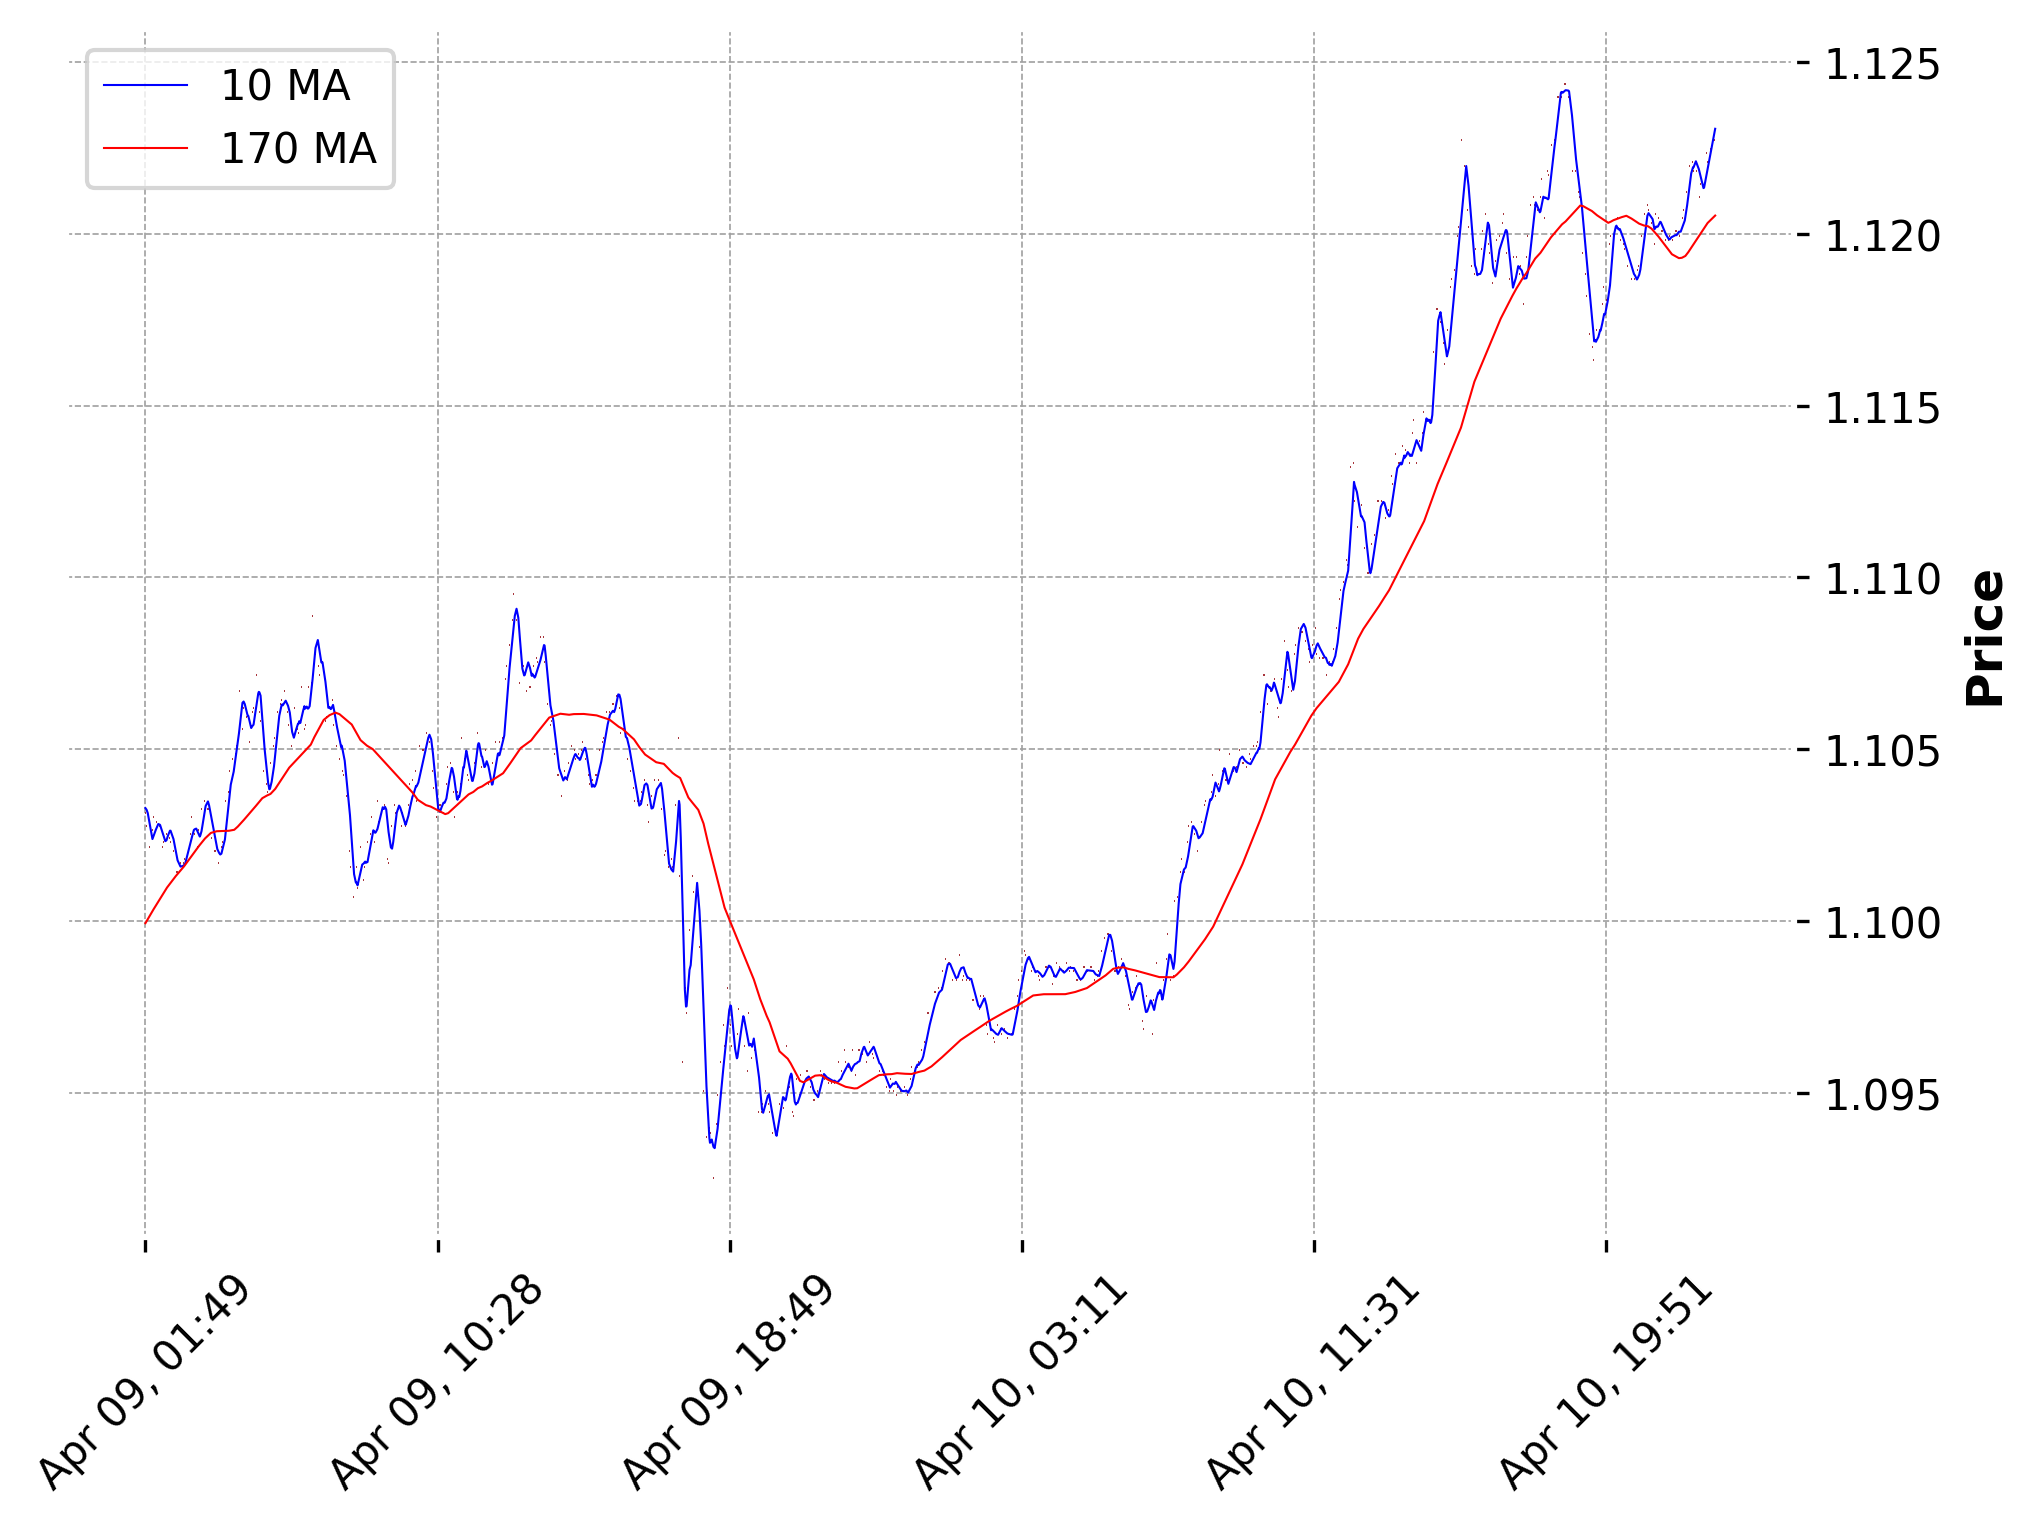

In [47]:
plot_chart()

Total Profit: $22.78
Total Trades: 12


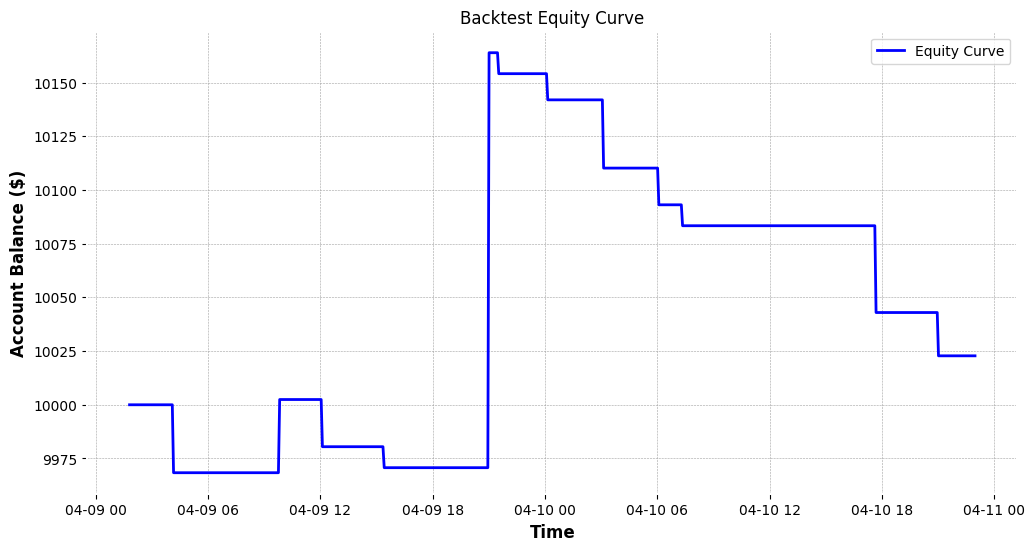

In [48]:
plot_equity_curve(trades_opt)

In [49]:
profit_unscaled_new = data['Profit']

In [50]:
df[df['Signal'] == 1]

,Close,High,Low,Open,MA_short,MA_long,Signal,Buy_Signal,Sell_Signal,Balance
Datetime,,,,,,,,,,
2025-04-09 04:07:00+00:00,1.103753,1.103753,1.103753,1.103753,1.102731,1.102611,1.0,1.103753,NaN,9968.371391
2025-04-09 09:47:00+00:00,1.103997,1.103997,1.103997,1.103997,1.103741,1.103686,1.0,1.103997,NaN,10002.442973
2025-04-09 12:04:00+00:00,1.105094,1.105094,1.105094,1.105094,1.104192,1.104127,1.0,1.105094,NaN,9980.479258
2025-04-09 15:22:00+00:00,1.106072,1.106072,1.106072,1.106072,1.105901,1.105877,1.0,1.106072,NaN,9970.716039
2025-04-09 20:58:00+00:00,1.095530,1.095530,1.095530,1.095530,1.095386,1.095357,1.0,1.095530,NaN,10163.875746
2025-04-09 21:29:00+00:00,1.095530,1.095530,1.095530,1.095530,1.095494,1.095490,1.0,1.095530,NaN,10154.119714
2025-04-10 00:06:00+00:00,1.095650,1.095650,1.095650,1.095650,1.095602,1.095582,1.0,1.095650,NaN,10141.935170
2025-04-10 03:05:00+00:00,1.098298,1.098298,1.098298,1.098298,1.097695,1.097575,1.0,1.098298,NaN,10110.171983
2025-04-10 06:02:00+00:00,1.099143,1.099143,1.099143,1.099143,1.098744,1.098667,1.0,1.099143,NaN,10093.084283


In [51]:
data

,Time_Diff,Signal,Profit
Datetime,,,
2025-04-09 03:46:00+00:00,0 days 00:21:00,-1.0,-31.628609
2025-04-09 07:32:00+00:00,0 days 02:15:00,-1.0,34.071582
2025-04-09 12:00:00+00:00,0 days 00:04:00,-1.0,-21.963716
2025-04-09 13:45:00+00:00,0 days 01:37:00,-1.0,-9.763218
2025-04-09 15:49:00+00:00,0 days 05:09:00,-1.0,193.159707
2025-04-09 21:06:00+00:00,0 days 00:23:00,-1.0,-9.756032
2025-04-09 23:15:00+00:00,0 days 00:51:00,-1.0,-12.184545
2025-04-10 02:14:00+00:00,0 days 00:51:00,-1.0,-31.763187
2025-04-10 05:53:00+00:00,0 days 00:09:00,-1.0,-17.087700


In [52]:
profit_unscaled_new

Datetime
2025-04-09 03:46:00+00:00    -31.628609
2025-04-09 07:32:00+00:00     34.071582
2025-04-09 12:00:00+00:00    -21.963716
2025-04-09 13:45:00+00:00     -9.763218
2025-04-09 15:49:00+00:00    193.159707
2025-04-09 21:06:00+00:00     -9.756032
2025-04-09 23:15:00+00:00    -12.184545
2025-04-10 02:14:00+00:00    -31.763187
2025-04-10 05:53:00+00:00    -17.087700
2025-04-10 06:08:00+00:00     -9.743428
2025-04-10 17:29:00+00:00    -40.400158
2025-04-10 19:09:00+00:00    -20.156258
Name: Profit, dtype: float64

In [53]:
data = processed_data(data)

In [54]:
data = scaled_data(data)

In [55]:
# Define features and target
feature_cols = ['Time_Diff_Hours', 'Year', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',  'Hour', 'Minute' ]
target_col = 'Profit'  # Or 'Signal' for classification
seq_length = 1# Use past 5 time steps

X, y = create_sequences(data, seq_length, feature_cols, target_col)

In [56]:
X

array([[[ 0.0557377 ,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.04761905,  0.86792453]],

       [[ 0.4295082 ,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.23809524,  0.60377358]],

       [[ 0.        ,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.47619048,  0.        ]],

       [[ 0.30491803,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.52380952,  0.8490566 ]],

       [[ 1.        ,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.61904762,  0.9245283 ]],

       [[ 0.06229508,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  0.9047619 ,  0.11320755]],

       [[ 0.15409836,  0.        ,  0.8660254 , -0.5       ,
          0.97492791, -0.22252093,  1.        ,  0.28301887]],

       [[ 0.15409836,  0.        ,  0.8660254 , -0.5       ,
          0.43388374, -0.90096887,  0.        ,  0.26415094]],



In [57]:
# Evaluate
loss = model.evaluate(X, y)
print(f"Test Loss: {loss}")

# Predict
y_pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0681
Test Loss: 0.06810116767883301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


In [58]:
y_pred_actual = y_pred*( max(profit_unscaled) - min(profit_unscaled) ) + min(profit_unscaled)

In [59]:
y_pred_actual

array([[-4.738064  ],
       [-5.7397003 ],
       [-1.3842354 ],
       [-4.2846184 ],
       [-5.287567  ],
       [-0.62981033],
       [-1.1199112 ],
       [-6.2934303 ],
       [-5.1861687 ],
       [-5.4594383 ],
       [-2.5120735 ],
       [-3.9258347 ]], dtype=float32)

In [60]:
y_actual = y*( max(profit_unscaled_new) - min(profit_unscaled_new) ) + min(profit_unscaled_new)

In [61]:
y_actual

array([-31.6286087 ,  34.0715819 , -21.9637155 ,  -9.7632185 ,
       193.15970701,  -9.75603193, -12.18454469, -31.76318655,
       -17.08770017,  -9.74342782, -40.40015771, -20.15625829])

In [62]:
data

,Time_Diff,Profit,Datetime,Year,Month,Day,Hour,Minute,DayOfWeek,Time_Diff_Hours,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,Signal_0
0,0 days 00:21:00,0.037556,2025-04-09 03:46:00+00:00,0.0,0.0,0.0,0.047619,0.867925,0.0,0.055738,0.866025,-0.5,0.974928,-0.222521,True
1,0 days 02:15:00,0.318855,2025-04-09 07:32:00+00:00,0.0,0.0,0.0,0.238095,0.603774,0.0,0.429508,0.866025,-0.5,0.974928,-0.222521,True
2,0 days 00:04:00,0.078937,2025-04-09 12:00:00+00:00,0.0,0.0,0.0,0.476190,0.000000,0.0,0.000000,0.866025,-0.5,0.974928,-0.222521,True
3,0 days 01:37:00,0.131174,2025-04-09 13:45:00+00:00,0.0,0.0,0.0,0.523810,0.849057,0.0,0.304918,0.866025,-0.5,0.974928,-0.222521,True
4,0 days 05:09:00,1.000000,2025-04-09 15:49:00+00:00,0.0,0.0,0.0,0.619048,0.924528,0.0,1.000000,0.866025,-0.5,0.974928,-0.222521,True
5,0 days 00:23:00,0.131205,2025-04-09 21:06:00+00:00,0.0,0.0,0.0,0.904762,0.113208,0.0,0.062295,0.866025,-0.5,0.974928,-0.222521,True
6,0 days 00:51:00,0.120807,2025-04-09 23:15:00+00:00,0.0,0.0,0.0,1.000000,0.283019,0.0,0.154098,0.866025,-0.5,0.974928,-0.222521,True
7,0 days 00:51:00,0.036980,2025-04-10 02:14:00+00:00,0.0,0.0,1.0,0.000000,0.264151,1.0,0.154098,0.866025,-0.5,0.433884,-0.900969,True
8,0 days 00:09:00,0.099814,2025-04-10 05:53:00+00:00,0.0,0.0,1.0,0.142857,1.000000,1.0,0.016393,0.866025,-0.5,0.433884,-0.900969,True
9,0 days 01:10:00,0.131259,2025-04-10 06:08:00+00:00,0.0,0.0,1.0,0.190476,0.150943,1.0,0.216393,0.866025,-0.5,0.433884,-0.900969,True
